<a href="https://colab.research.google.com/github/AmiranGozalishvili/Data_Science_course/blob/main/Large_Movie_Dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pandas_profiling --upgrade
!pip install contractions
!pip install autocorrect
!pip install opendatasets

In [ ]:
import os.path
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import contractions
import opendatasets
import spacy
import json


from tqdm.notebook import tqdm_notebook
# # initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = 7, 7
plt.style.use('ggplot')

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import SCORERS, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud

from sklearn.metrics import make_scorer, fbeta_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Import dataframe

In [ ]:
data = pd.read_csv('/content/LargeMovieReviewDataset.csv', engine='python', encoding='utf-8')

# EDA

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
data.review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

EDA conclusion: from review of dataframe we see that there are two column,

'review' and 'sentiment'. column 'sentiment' is our target.

also we can see that there are no missing rows, but we have some duplicated

rows, which can be droped from our data.

also 'possitive' and 'negative' categories are balanced, so

we can pass this part of preparation with no action.

we could change our target column categories 'positive' with 1

and 'negative' with 0. (convert to binary)

Column 'review' needs some steps to be prepared, like clean slang word,

stop words filter and so on.

# Data preparation

# Clean slang

search in data if there are slang words

there are some examples which type of slang words can appear in data

so with slang cleaning we can update that words

In [ ]:
def clean_slang(text):
  """
  Correct common slang and abbreviations.
  """
  text = re.sub(r"\babt?\b", "about", str(text))
  text = re.sub(r"\bcomfy\b", "comfortable", str(text))
  text = re.sub(r"\brll?y\b", "really", str(text))
  text = re.sub(r"\bso{2,}\b", "so", str(text))
  text = re.sub(r"\bmed\b", "medium", str(text))
  text = re.sub(r"\bxx?s\b", "extra small", str(text))
  text = re.sub(r"\bxx?l\b", "extra large", str(text))
  text = re.sub(r"\bfab\b", "fabulous", str(text))
  text = re.sub(r"\bblk\b", "black", str(text))
  text = re.sub(r"\bpromo\b", "promotion", str(text))
  text = re.sub(r"\btts\b", "true to size", str(text))
  text = re.sub(r"\blbs?\b", "pounds", str(text))
  text = re.sub(r"\brn\b", "right now", str(text))
  text = re.sub(r"\bwanna\b", "want to", str(text))
  text = re.sub(r"\besp\b", "especially", str(text))
  text = re.sub(r"\bgonn[ao]\b", "going to", str(text))
  text = re.sub(r"\btho\b", "though", str(text))
  text = re.sub(r"altho ", "although ", str(text))
  text = re.sub(r"prolly", "probably", str(text))
  text = re.sub(r"asap", "as soon as possible", str(text))
  text = re.sub(r"\bbc|b/c\b", "because", str(text))
  text = re.sub(r"\bavail\b", "available", str(text))
  text = re.sub(r"\bdiff\b", "different", str(text))
  text = re.sub(r"\bnxt|enxt\b", "next", str(text))
  text = re.sub(r" w/ ", " with ", str(text))
  text = re.sub(r"\bdidn ", "didn't ", str(text))
  text = re.sub(r" dnt ", " don't ", str(text))
  text = re.sub(r"\bsnd\b", "send", str(text))
  text = re.sub(r"b4\b", "before", str(text))
  text = re.sub(r"stink'n", "stinking", str(text))
  text = re.sub(r"\batm\b", "at the moment", str(text))
  text = re.sub(r"\besp\b", "especially", str(text))
  text = re.sub(r"\bavg\b", "average", str(text))
  text = re.sub(r"(\d'|\d\")\s?(\d+'|\d+\")?", " ", str(text)) # removes height measurements
  text = re.sub(r"'\d+\w+'", " ", str(text))
  text = re.sub(r"\s{2,}", " ", str(text)).strip()

  return text

# Contraction
Contractions are words or combinations of words that are shortened

by dropping letters and replacing them by an apostrophe.

e.g. don't >> do not

In [ ]:
def cont_expand(text):
  expanded_text = []
  for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_text.append(contractions.fix(word))   #contractions.fix
  return expanded_text

# stop words filter

stop words has library of words which can remove from sentence without loosing main idea of sentence.

stop words: an, the, and, but, if

In [ ]:
def stop_word_filter(text):
  sw = stopwords.words('english')
  filtered_words = [word for word in text if word not in sw]
  return filtered_words

# tokenize

tokenization is used in natural language processing to split paragraphs and

sentences into smaller units that can be more easily assigned meaning.

tokenizer breaks sentences down into words. which allows machine to understand

meaning of each word

In [ ]:
def tokenize(text):
  tokenized_text = []
  for i in text:
    tokenized_text.extend(word_tokenize(i))
  return tokenized_text

# Stemming
Stemming is the process of producing morphological variants of a root/base word.

Stemming programs are commonly referred to as stemming algorithms or stemmers.

e.g. loved, loving, or loves ===> love


In [ ]:
def stemming(text):
  """
  Strip suffixes from a word and return the stem.
  It is inefficient to have the algorithm process multiple formats of a word.
  """
  # creating an object of the PorterStemmer class
  ps = PorterStemmer()

  stemmed_review = [ps.stem(word) for word in text if word not in set(stopwords.words("english"))]
  return ' '.join(stemmed_review)

# Lemmatization

Lemmatization is the grouping together of different forms of the same word.

Lemmatization usually refers to doing things properly with the use of a

vocabulary and morphological analysis of words, normally aiming to remove

inflectional endings only and to return the base or dictionary form of a word,

which is known as the lemma .

In [ ]:
def lem_text(text):
  # Create WordNetLemmatizer object
  wnl = WordNetLemmatizer()

  lemmatized = [wnl.lemmatize(i) for i in text]
  return ''.join(lemmatized)

In [ ]:
def run_preprocess_data(df):
  print('running clean slang')
  df['review'] = df['review'].progress_apply(clean_slang)
  print('running contraction expand')
  df['review'] = df['review'].progress_apply(cont_expand)
  print('running stop_word_filter')
  df["review"] = df["review"].progress_apply(stop_word_filter)
  print('running tokenizer')
  df["review"] = df["review"].progress_apply(tokenize)
  print('running stemming')
  df['review'] = df['review'].progress_apply(stemming)
  print('running lematizaton')
  df['review'] = df['review'].progress_apply(lem_text)

  # save oprepared dataframe
  print('saving prepared dataframe')
  df.to_csv('LargeMovieReviewDataset_prepared.csv')
  return df

drop duplicate rows and convert them lowercase

It took big time to clean and prepare dataset and i decided to save prepared

.csv file, so I created logic: if no preprepared data file exists,

run all preparation processes and generate new file.

In [ ]:
if os.path.exists('/content/LargeMovieReviewDataset_prepared.csv'):
  data = pd.read_csv('/content/LargeMovieReviewDataset_prepared.csv', engine='python')
  df = data
else:
  data = pd.read_csv('/content/LargeMovieReviewDataset.csv', engine='python', encoding='utf-8')
  df = data

  # drop duplicate data
  drop = df.drop_duplicates(keep='last')
  df = drop

  # drop any rows with missing review
  df.dropna(axis=0, how='any', subset=['review'], inplace=True)

  # make all characters uniformly lowercase in order to ignoring case
  df['review'] = df['review'].apply(lambda x: str(x.lower()))
  print('fill done')
  run_preprocess_data(df)


In [ ]:
df = df[['review', 'sentiment']]

conclusion of data preparation:

as we saw into EDA part. in our dataset we have columns 'review',

which contains positive and negative reviews about movies.

in texts we have many useless contents which are not important for machine

when it makes computations. if data contains this type of contant, this will

increase the calculation time and reduce the effective performance of the model.

steps which we have in data preparation part, like lemmatization,

stop words filter, stemming, tokenization and so on, they are a prerequisite

for having relatively small dimensional vectors after TF-IDF vectorization.

This is exactly our goal to increase the efficiency of the model.

At this point all data preparation processes are done and we can train some

models to see which one gives us best scores.

# Train Test split

convert target data categories 'positive' == 1 and 'negative' == 0

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

In [ ]:
X = df['review']   #[:10000]
y = df['sentiment']   #[:10000]

In [ ]:
random_state=42

In [ ]:
# splitting the df into an 70% training and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=random_state,
                                                    shuffle=True)

# TF-IDF

TF-IDF assigns high weights to words that are present in one text and are not

present in many other text.

Accordingly, stopwords will automatically have a low coefficient because they

are in almost all texts and cannot make a difference.

after TF-IDF process instead of text we will get vectors of assigned

weights of words. it's numerical representation of text.

In [ ]:
def tf_idf(X_train, X_test):

    # max_feature helps condense the sparse matrix by keeping only the top n number of words in the corpus' vocabulary
    # in this case, the 1500 most frequent words are kept
    vectorizer = TfidfVectorizer(max_features=2000)

    # generate wordcloud
    X_tr_cloud = vectorizer.fit_transform(X_train)
    tfidf_weights = [(word, X_tr_cloud.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

    tfidf_weights[0:10]

    w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))


    # create the matrix
    X_train = vectorizer.fit_transform(X_train).toarray()

    X_test = vectorizer.transform(X_test).toarray()

    plt.figure(figsize=(20,15))
    plt.imshow(w)
    plt.axis('off')
    plt.savefig('recipes_wordcloud.png')

    return X_train, X_test

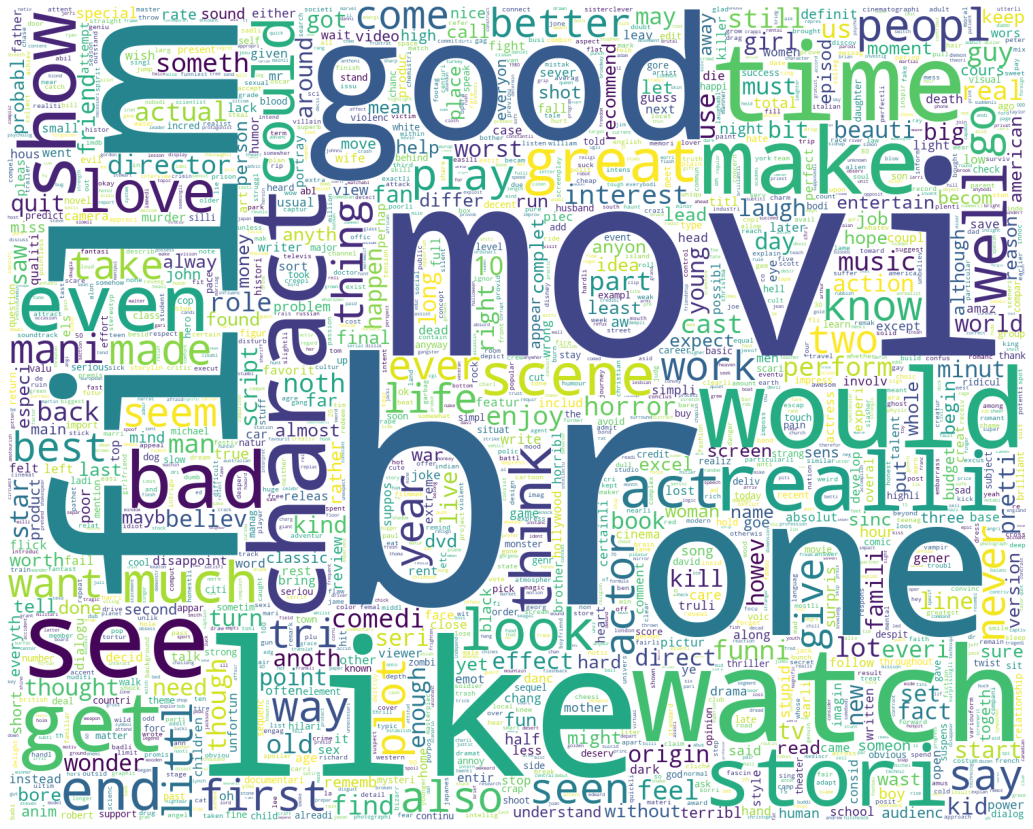

In [ ]:
X_train, X_test = tf_idf(X_train, X_test)

Wordcloud gives us picture of most wighted words with descending order

# SGD classifier

In [ ]:
def SGD_classifier(X_train, X_test):
    sgdc_model = SGDClassifier(loss='log', max_iter=3000, tol=0.0001,
                               penalty='l2', n_jobs=-1, shuffle=True,
                               random_state=random_state)
    print(sgdc_model)

    sgdc_model.fit(X_train, y_train)

    # print("Score: ", sgdc_model.score(X_train, y_train))

    sgd_y_pred = sgdc_model.predict(X_test)

    print('SGD Metrics')

    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')
    res = fbeta_score(y_test, sgd_y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print(classification_report(y_test, sgd_y_pred))

    # confusion matrix
    plot_confusion_matrix(sgdc_model, X_test, y_test)
    plt.title('Confusion Matrix')

    # ROC curve
    plot_roc_curve(sgdc_model, X_test, y_test)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    return sgdc_model, sgd_y_pred

SGDClassifier(loss='log', max_iter=3000, n_jobs=-1, random_state=42, tol=0.0001)
SGD Metrics

====F2 scores:====
         F2
0  0.860059
1  0.888551
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7443
           1       0.86      0.90      0.88      7432

    accuracy                           0.87     14875
   macro avg       0.88      0.87      0.87     14875
weighted avg       0.88      0.87      0.87     14875



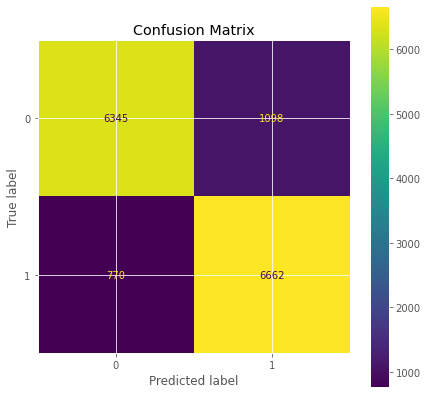

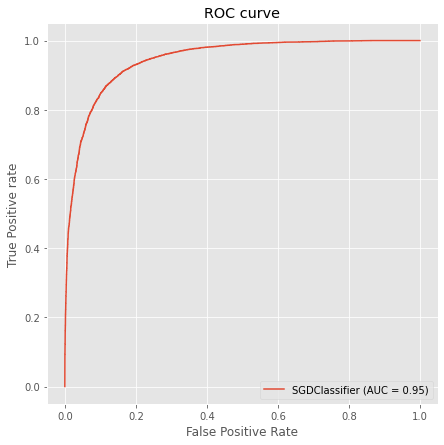

In [ ]:
sgdc_model, sgd_y_pred = SGD_classifier(X_train, X_test)

In [ ]:
def grid_search_sgd():
    '''Grid-Search'''

    parameters = {
                  'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
                  'max_iter': [2000], # number of epochs
                  'loss': ['hinge','log_loss'], # default, logistic regression,
                  'penalty': ['l2'],
                  'n_jobs': [-1]
                  }
    # determine which combination of parameters leads to the best results
    grid_search = GridSearchCV(estimator=sgdc_model,
                               param_grid=parameters,
                               scoring='accuracy')

    grid = grid_search.fit(X_train, y_train)

    print('Best accuracy: {}'.format(grid.best_score_))
    print('Best parameters: {}'.format(grid.best_params_))
    return grid

In [ ]:
grid_search_sgd()

Best accuracy: 0.8723888230930734
Best parameters: {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2'}


GridSearchCV(estimator=SGDClassifier(loss='log', max_iter=3000, random_state=42,
                                     tol=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                         'loss': ['hinge', 'log_loss'], 'max_iter': [2000],
                         'n_jobs': [-1], 'penalty': ['l2']},
             scoring='accuracy')

grid search is usefull to determine which parameters can give us best scores

for different estimators.

# SVM classifier

In [ ]:
def SVM_classifier(X_train, X_test):
    #Create a svm Classifier
    svm_model = svm.SVC(cache_size=500, C=1, gamma=0.01, probability=True,
                        degree=3, max_iter=1000,
                        random_state=random_state)

    #Train the model using the training sets
    svm_model.fit(X_train, y_train)

    #Predict the response for test dataset
    svm_y_pred = svm_model.predict(X_test)

    print('SVM Metrics')

    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')

    res = fbeta_score(y_test, svm_y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print(classification_report(y_test, svm_y_pred))

    # confusion matrix
    plot_confusion_matrix(svm_model, X_test, y_test)
    plt.title('Confusion Matrix')

    # ROC curve
    plot_roc_curve(svm_model, X_test, y_test)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    return svm_model, svm_y_pred

SVM Metrics

====F2 scores:====
         F2
0  0.503286
1  0.881400
              precision    recall  f1-score   support

           0       0.95      0.45      0.61      7443
           1       0.64      0.97      0.77      7432

    accuracy                           0.71     14875
   macro avg       0.79      0.71      0.69     14875
weighted avg       0.79      0.71      0.69     14875



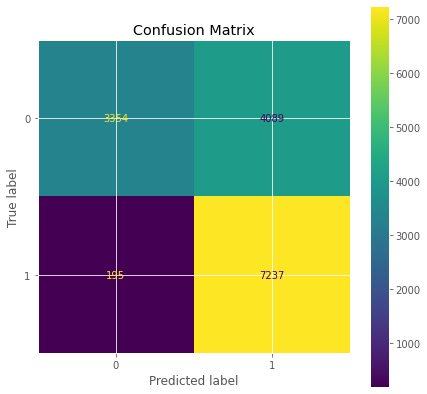

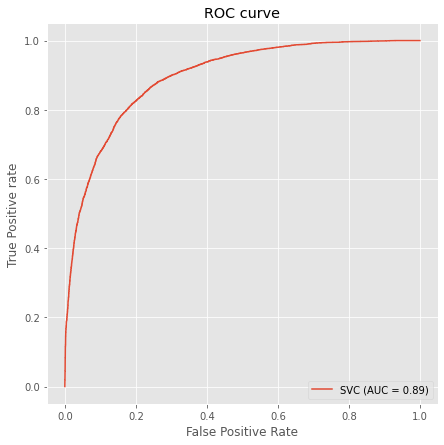

In [ ]:
svm_model, svm_y_pred = SVM_classifier(X_train, X_test)

# Gaussian Naive Bayes

In [ ]:
def GNB_classifier(X_train, X_test):
    #Create a Gaussian Classifier
    gnb_model = GaussianNB()

    #Train the model using the training sets
    gnb_model.fit(X_train, y_train)

    #Predict the response for test dataset
    nb_y_pred = gnb_model.predict(X_test)

    print('Gaussian Naive Bayes Metrics')
    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')

    res = fbeta_score(y_test, nb_y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print(classification_report(y_test, nb_y_pred))

    # confusion matrix
    plot_confusion_matrix(gnb_model, X_test, y_test)
    plt.title('Confusion Matrix')

    # ROC curve
    plot_roc_curve(gnb_model, X_test, y_test)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    return gnb_model, nb_y_pred

Gaussian Naive Bayes Metrics

====F2 scores:====
         F2
0  0.810067
1  0.806599
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7443
           1       0.81      0.81      0.81      7432

    accuracy                           0.81     14875
   macro avg       0.81      0.81      0.81     14875
weighted avg       0.81      0.81      0.81     14875



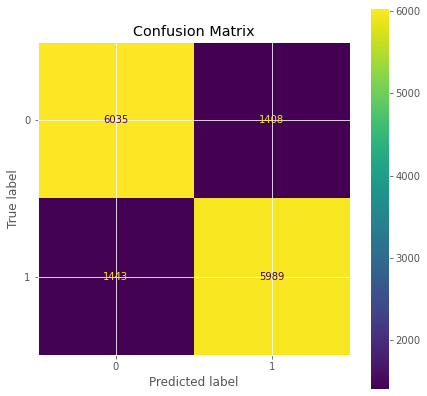

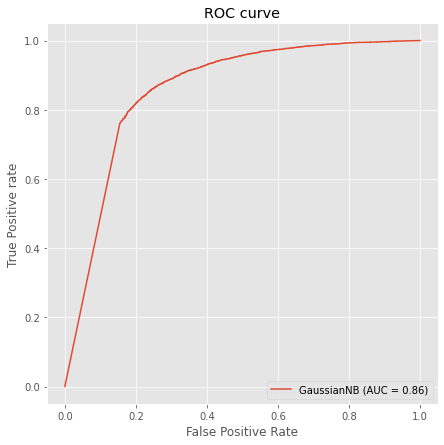

In [ ]:
gnb_model, nb_y_pred = GNB_classifier(X_train, X_test)

# Logistic Regression classifier

In [ ]:
def LR_classifier(X_train, X_test):
    #Create a Gaussian Classifier
    log_reg_model = LogisticRegression(solver='saga',max_iter=500,
                                       random_state=random_state)

    #Train the model using the training sets
    log_reg_model.fit(X_train, y_train)

    #Predict the response for test dataset
    lr_y_pred = log_reg_model.predict(X_test)
    print('LogisticRegression Metrics')

    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')

    res = fbeta_score(y_test, lr_y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print(classification_report(y_test, lr_y_pred))

    # confusion matrix
    plot_confusion_matrix(log_reg_model, X_test, y_test)
    plt.title('Confusion Matrix')

    # ROC curve
    plot_roc_curve(log_reg_model, X_test, y_test)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    return log_reg_model, lr_y_pred

LogisticRegression Metrics

====F2 scores:====
         F2
0  0.870680
1  0.885764
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      7443
           1       0.87      0.89      0.88      7432

    accuracy                           0.88     14875
   macro avg       0.88      0.88      0.88     14875
weighted avg       0.88      0.88      0.88     14875



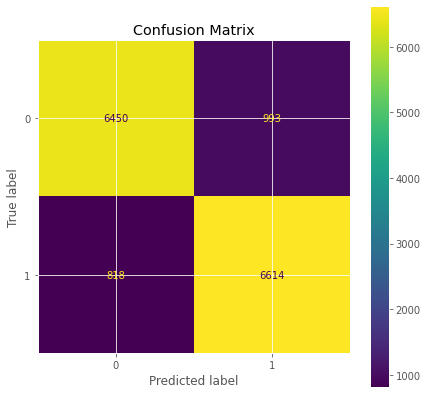

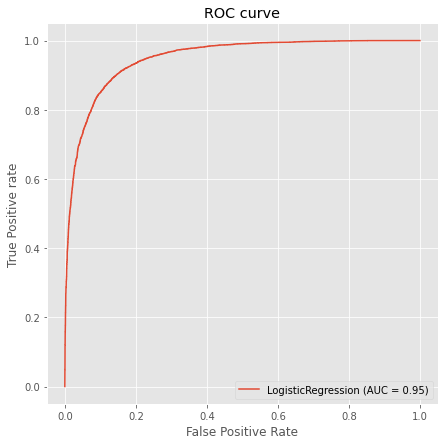

In [ ]:
log_reg_model, lr_y_pred = LR_classifier(X_train, X_test)

# RandomForest

In [ ]:
def RF_classifier(X_train, X_test):
    # fit the optimized Random Forest model onto the training set
    rf_model = RandomForestClassifier(n_estimators=400,
                                        criterion='gini',
                                        random_state=random_state)
    rf_model.fit(X_train, y_train)

    # predict the test results
    rf_y_pred = rf_model.predict(X_test)

    print('RandomForest metrics')
    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')

    res = fbeta_score(y_test, rf_y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print(classification_report(y_test, rf_y_pred))

    # confusion matrix
    plot_confusion_matrix(rf_model, X_test, y_test)
    plt.title('Confusion Matrix')

    # ROC curve
    plot_roc_curve(rf_model, X_test, y_test)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    return rf_model, rf_y_pred

RandomForest metrics

====F2 scores:====
         F2
0  0.849888
1  0.851087
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7443
           1       0.85      0.85      0.85      7432

    accuracy                           0.85     14875
   macro avg       0.85      0.85      0.85     14875
weighted avg       0.85      0.85      0.85     14875



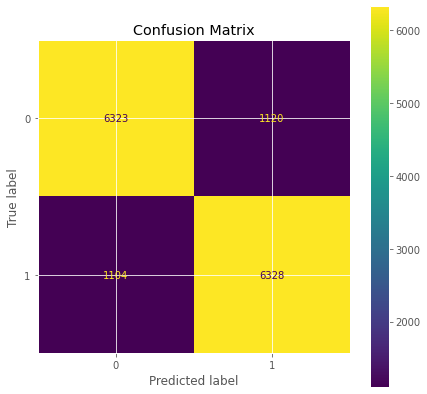

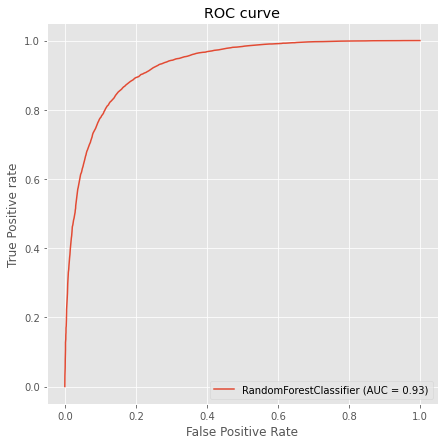

In [ ]:
rf_model, rf_y_pred = RF_classifier(X_train, X_test)

**TF-IDF:** can be a very handy metric for determining

how important a term is in a document.

TF-IDF vectorization involves calculating the TF-IDF score for every word in

our corpus relative to that document and then putting that information into a

vector.

**About Trained Models:**  

**SGD:**

difference between Gd and SGD is computation strategies. in GD we make

computation on whole data but in SGD, we randomly choose one point from the

dataset, compute the gradient, then update the parameters and repeat until convergence.

so we can say that compute large dataset with SGD is more efficient way.


From our computations, we

avg scores precision: 0.88, recall: 0.87, f1-score: 0.87, AUC score = 0.95


**SVM:**

SVM classifier separates data points using a hyperplane with the largest amount

of margin. it finds an optimal hyperplane which helps in classifying new data points.

SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees.

avg scores precision: 0.79, recall: 0.71, f1-score:0.69, AUC: 0.89


**Gaussian Naive Bayes:**

Naive Bayes is a statistical classification technique based on Bayes Theorem.

It is one of the simplest supervised learning algorithms

also has very low computation cost and can efficiently

work on a large dataset.

avg scores precision: 0.81, recall: 0.81, f1-score:0.81, AUC: 0.86


**Logistic Regression:**

avg scores precision: 0.88, recall: 0.88, f1-score:0.88, AUC: 0.95


**RandomForest:**

avg scores precision: 0.85, recall: 0.85, f1-score:0.85, AUC: 0.93


**AUC-ROC curve:**

An ROC curve is a graph showing the performance of a classification

model at all classification thresholds. This curve plots two parameters:

1) True Positive Rate

2) False Positive Rate

AUC is 'scale-invariant'. It measures how well predictions are ranked,

rather than their absolute values.

AUC is 'classification-threshold-invariant'. It measures the quality of the

model's predictions irrespective of what classification threshold is chosen.

**conclusion:**

I think from this equations, most important score are f1-score.

beacuse f1-score combines precision and recall scores.

We have high f1-scores: SGD model - 0.87 and LogisticRegression model - 0.88


AUC measures how well predictions are ranked, rather than their absolute values

and also it measures the quality of the model's predictions irrespective of

what classification threshold is chosen.


AUC scores: SGD model - 0.95 and LogisticRegression model - 0.95

# Plot

ROC curve different models

In [ ]:
# logistic regression
model1 = log_reg_model
# RandomForest
model2 = rf_model
# SGD
model3 = sgdc_model
# SVM
model4 = svm_model
# GNB
model5 = gnb_model


# fit model  model1.fit(X_train, y_train)
lr_y_pred  #logistic reg
rf_y_pred  #randomforest
sgd_y_pred  #SGD
svm_y_pred   #svm linear
nb_y_pred   #naive bayes

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)
pred_prob4 = model4.predict_proba(X_test)
pred_prob5 = model5.predict_proba(X_test)


In [ ]:
# plot_roc_curve(models, X_test, y_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

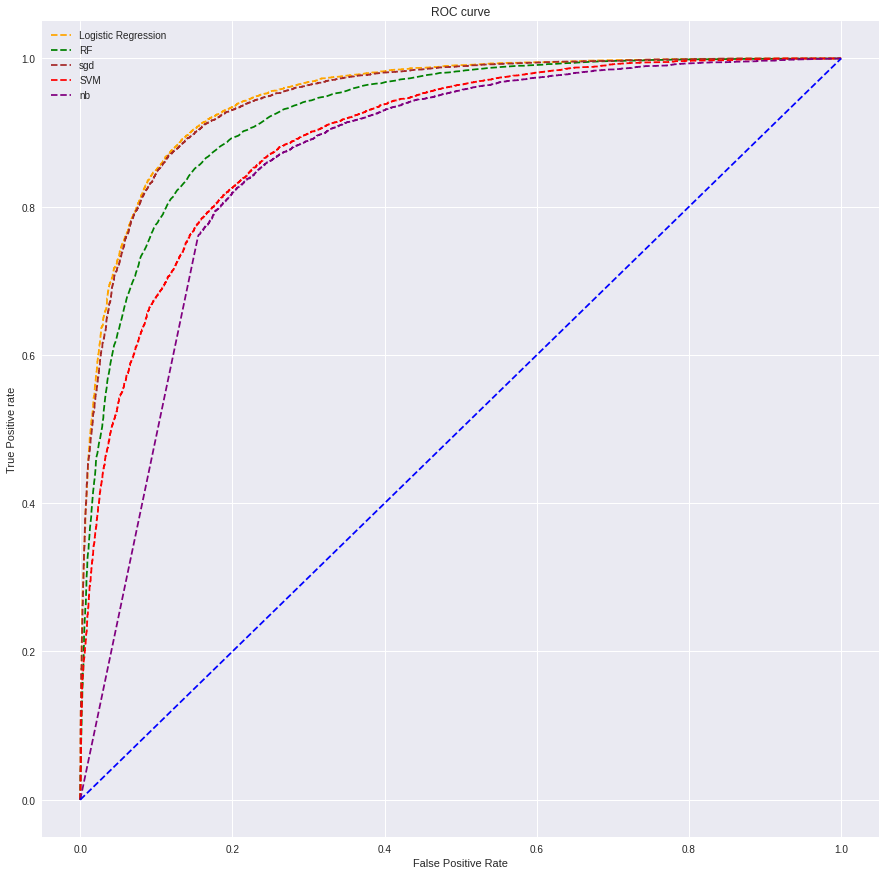

In [ ]:
# matplotlib
plt.style.use('seaborn')
plt.figure(figsize=(15,15))

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='RF')
plt.plot(fpr3, tpr3, linestyle='--',color='brown', label='sgd')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='SVM')
plt.plot(fpr5, tpr5, linestyle='--',color='purple', label='nb')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

ROC curve plot and difference between our models AUC scores

As we can see best scores has LogisticRegression and SGD classifiers

with score 0.95

The ROC curve model does the best job of distinguishing between

positive and negative classes.

We can choose whether 'false positive rate' is more important or

'true positive rate'.

wh have best ROC curve score if curve is near left top side.